# (Try to) identify signals of gentrification from Airbnb data

In [34]:
import os
import pandas as pd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
import sys
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

sys.path.insert(0, '../')
from PlottingFunctions import *

def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0]
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct, 'count': count})

city='melbourne'

### Get just Melbourne suburbs

In [2]:
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")
central_suburbs[['SAL_NAME21', "geometry"]].head()

SAL_NAME21                                           geometry
0   Abbotsford (Vic.)  POLYGON ((145.00195 -37.79665, 145.0019 -37.79...
1          Aberfeldie  POLYGON ((144.89576 -37.76514, 144.89547 -37.7...
2        Airport West  POLYGON ((144.87979 -37.71565, 144.88016 -37.7...
3  Albert Park (Vic.)  POLYGON ((144.95445 -37.83794, 144.95691 -37.8...
4       Albion (Vic.)  POLYGON ((144.82393 -37.77649, 144.82402 -37.7...

## Get gentrification scores for each listing

In [3]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
# score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_one_per_lsoa_10.csv')
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_02.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
# Remove rows with an error
score_per_listing = score_per_listing[score_per_listing['explanation'] != 'ERROR']
score_per_listing = score_per_listing[['gentrification_prediction', 'explanation', 'gentrification_prediction_code', 'longitude',
                                              'latitude']]
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

gentrification_prediction  \
0               Gentrifying   
1               Established   
2               Undeveloped   
3                  Emerging   
4               Undeveloped   

                                         explanation  \
0  The area is described as "hip" with an "arts c...   
1  The description highlights the area's central ...   
2  The listing lacks specific details about the n...   
3  The description mentions the suburb's "diverse...   
4  The listing focuses on the property's amenitie...   

   gentrification_prediction_code  longitude  latitude  
0                               3  144.97951 -37.76606  
1                               4  144.97662 -37.85999  
2                               1  145.00066 -37.69761  
3                               2  145.11579 -37.89983  
4                               1  145.14364 -38.14768

### Convert to geodataframe of scores per listing

In [4]:
score_per_listing['geometry'] = score_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
score_per_listing_gdf = gpd.GeoDataFrame(score_per_listing, geometry='geometry', crs="EPSG:4326")
score_per_listing_gdf.head()

gentrification_prediction  \
0               Gentrifying   
1               Established   
2               Undeveloped   
3                  Emerging   
4               Undeveloped   

                                         explanation  \
0  The area is described as "hip" with an "arts c...   
1  The description highlights the area's central ...   
2  The listing lacks specific details about the n...   
3  The description mentions the suburb's "diverse...   
4  The listing focuses on the property's amenitie...   

   gentrification_prediction_code  longitude  latitude  \
0                               3  144.97951 -37.76606   
1                               4  144.97662 -37.85999   
2                               1  145.00066 -37.69761   
3                               2  145.11579 -37.89983   
4                               1  145.14364 -38.14768   

                      geometry  
0  POINT (144.97951 -37.76606)  
1  POINT (144.97662 -37.85999)  
2  POINT (145.00066 -37.69761)  
3  POINT (145.11579 -37.89983)  
4  POINT (145.14364 -38.14768)

### Find which Suburb each listing is within

In [5]:
score_per_listing_with_suburb = gpd.sjoin(
    score_per_listing_gdf,
    central_suburbs[['SAL_NAME21', 'geometry']],
    how='right',
    predicate='within')

del score_per_listing_with_suburb['geometry']
del score_per_listing_with_suburb['index_left']
score_per_listing_with_suburb.reset_index(inplace=True, drop=True)
score_per_listing_with_suburb.head()

gentrification_prediction  \
0                  Emerging   
1               Gentrifying   
2               Gentrifying   
3               Gentrifying   
4               Gentrifying   

                                         explanation  \
0  The listing describes the area as "green, safe...   
1  The area is described as "trendy" and "modern"...   
2  The suburb of Abbotsford is described as havin...   
3  The neighborhood is described as eclectic with...   
4  The neighborhood is described as having a "gre...   

   gentrification_prediction_code  longitude  latitude         SAL_NAME21  
0                             2.0  144.99975 -37.79906  Abbotsford (Vic.)  
1                             3.0  145.01346 -37.81176  Abbotsford (Vic.)  
2                             3.0  144.99755 -37.79846  Abbotsford (Vic.)  
3                             3.0  145.00404 -37.80942  Abbotsford (Vic.)  
4                             3.0  144.99663 -37.80311  Abbotsford (Vic.)

## Create a dataframe with a count of the number of listings in each LSOA, and the modal score

In [6]:
per_suburb_summary = (score_per_listing_with_suburb
    .groupby("SAL_NAME21")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_suburb_summary = central_suburbs[['SAL_NAME21', 'geometry']].merge(per_suburb_summary, on='SAL_NAME21')
per_suburb_summary = per_suburb_summary[per_suburb_summary['dominant_class'].notnull()]
per_suburb_summary['dominant_class'] = per_suburb_summary['dominant_class'].astype(int)
per_suburb_summary.head()

SAL_NAME21                                           geometry  \
0   Abbotsford (Vic.)  POLYGON ((145.00195 -37.79665, 145.0019 -37.79...   
1          Aberfeldie  POLYGON ((144.89576 -37.76514, 144.89547 -37.7...   
2        Airport West  POLYGON ((144.87979 -37.71565, 144.88016 -37.7...   
3  Albert Park (Vic.)  POLYGON ((144.95445 -37.83794, 144.95691 -37.8...   
4       Albion (Vic.)  POLYGON ((144.82393 -37.77649, 144.82402 -37.7...   

   dominant_class  dominant_pct  count  
0               3     62.318841  207.0  
1               4     66.666667    3.0  
2               1     36.363636   22.0  
3               4     84.761905  105.0  
4               1     46.666667   15.0

In [7]:
cmap = plt.get_cmap('viridis', 5)
plot_colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), plot_colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

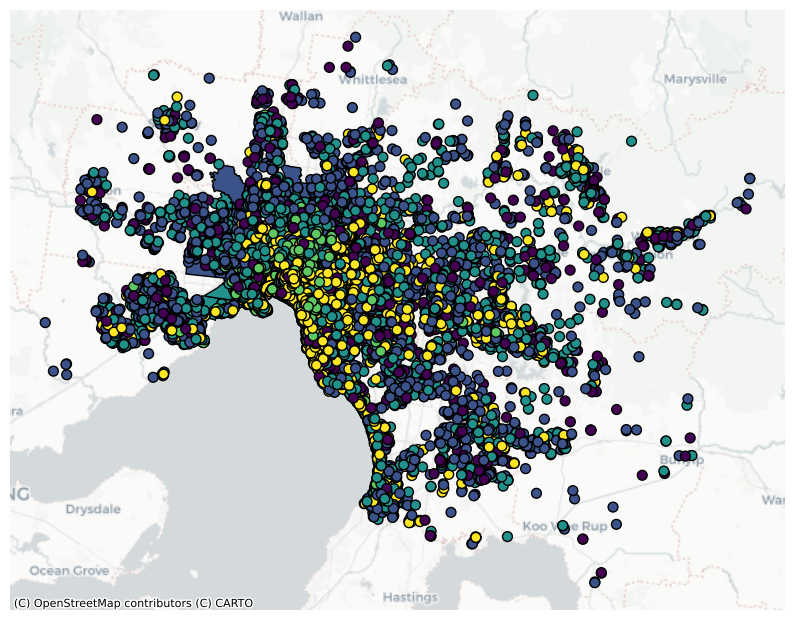

In [8]:
per_suburb_summary['color'] = per_suburb_summary['dominant_class'].map(cmap)
plot_colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), plot_colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

fig,ax=plt.subplots(figsize=(10,10))

# Plot using the 'color' column directly
per_suburb_summary_wm = per_suburb_summary.to_crs(epsg=3857)
per_suburb_summary_wm.plot(color=per_suburb_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

score_per_listing_gdf_wm = score_per_listing_gdf.to_crs(epsg=3857)
score_per_listing_gdf_wm.plot(color=score_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black', markersize=50);

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=score_per_listing_gdf_wm.crs)

ax.axis("off");

## Plot

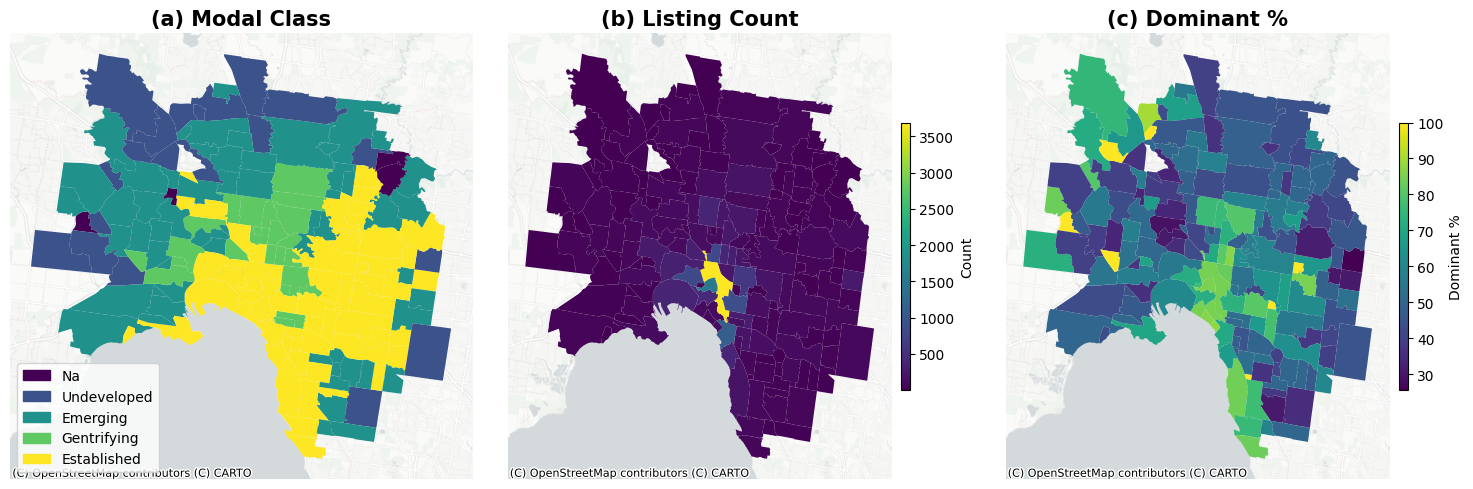

In [9]:
# Common legend keyword settings
legend_opts = {
    "shrink": 0.6,
    "orientation": "vertical",
    "pad": 0.02,
    "aspect": 30}

# Ensure CRS is web mercator for basemap
per_suburb_summary = per_suburb_summary.to_crs(epsg=3857)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # wider but flatter

per_suburb_summary.plot(color=per_suburb_summary["color"], ax=axs[0], legend=False)

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches = [mpatches.Patch(color=per_suburb_summary.loc[per_suburb_summary["dominant_class"] == k, "color"].iloc[0], label=label) 
           for k, label in class_labels.items()]

axs[0].legend(handles=patches, loc="lower left", frameon=True, prop={'size': 10})
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[0].set_title("(a) Modal Class", fontweight='bold', fontsize=15);

# First plot: count
per_suburb_summary.plot(
    "count", alpha=1, ax=axs[1], legend=True,
    legend_kwds={"label": "Count", **legend_opts})
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[1].set_title("(b) Listing Count", fontweight='bold', fontsize=15)

# Third plot: dominant percent
per_suburb_summary.plot(
    "dominant_pct", alpha=1, ax=axs[2], legend=True,
    legend_kwds={"label": "Dominant %", **legend_opts})
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[2].set_title("(c) Dominant %", fontweight='bold', fontsize=15)

# Tidy up
for ax in axs:
    ax.axis('off')
for ax in axs:
    ax.set_aspect('auto')  # instead of the default 'equal'

plt.tight_layout()
fig.savefig("../Figures/Melbourne_LLM-scores.png", bbox_inches = 'tight')
plt.show()

# Gentrification index comparison

In [10]:
g_index = pd.read_csv(f"../../../data/GentrificationIndex/MelbourneIndex/FromGuardian.csv")
g_index = g_index.merge(central_suburbs, on='SAL_NAME21', how='left')
g_index = g_index[g_index['geometry'].notnull()]
g_index_gdf = gpd.GeoDataFrame(g_index, geometry='geometry', crs="EPSG:4326")

# Add colour column to plot from
cmap = plt.get_cmap('viridis', 9)
colors = [cmap(i) for i in range(9)]
color_map = dict(zip(range(9), colors))
g_index_gdf['color']= g_index_gdf['Classification'].map(color_map)

In [33]:
# np.unique(g_index['Classification'], return_counts=True)

# (len(g_index['Classification'])-7)/len(g_index['Classification']) * 100

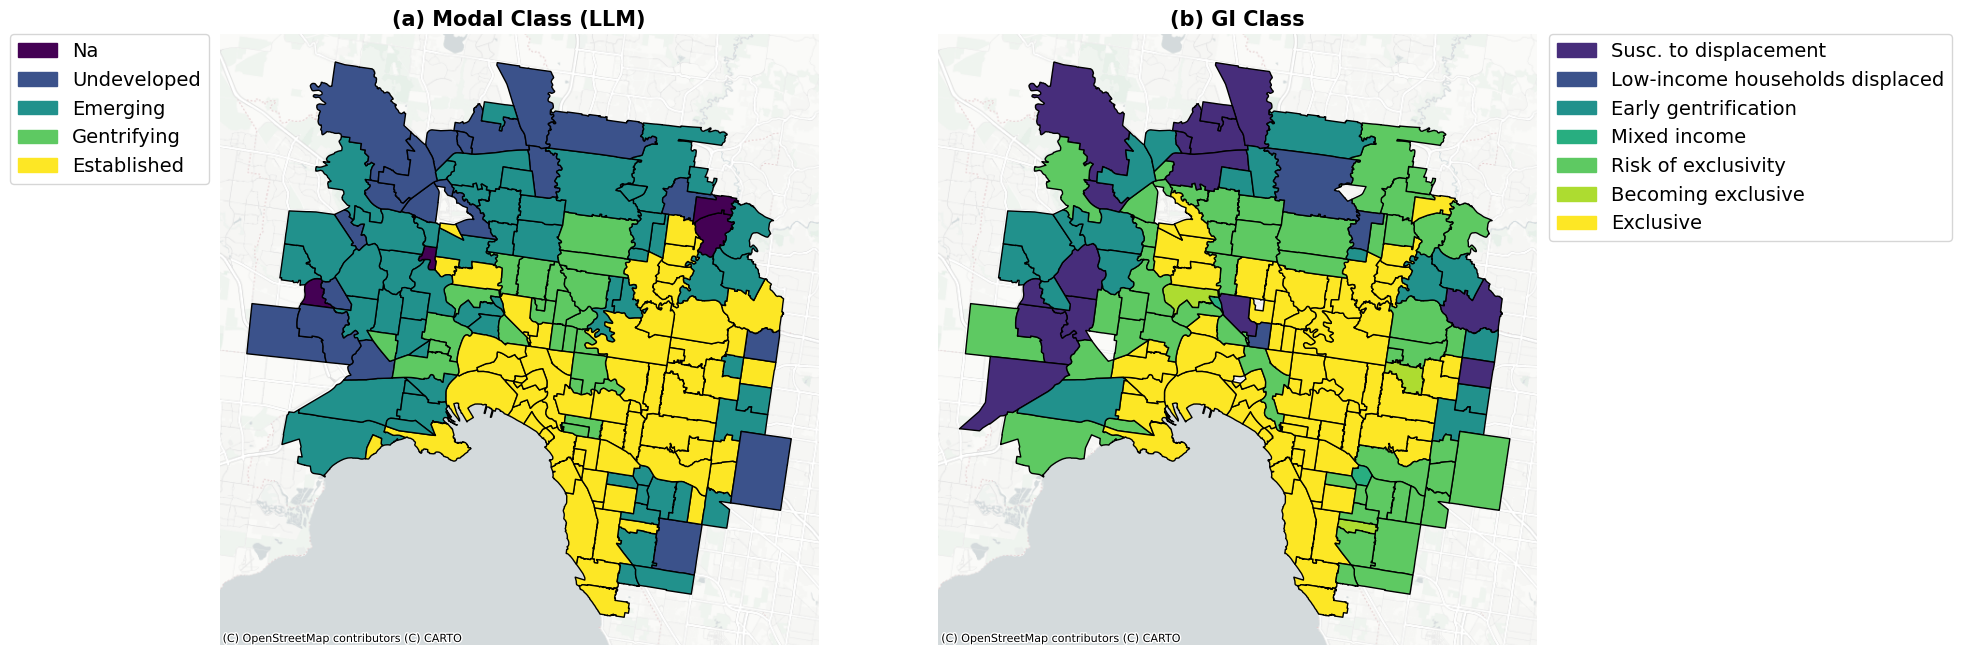

In [12]:
fig, axs = plt.subplots(ncols = 2, figsize=(17, 10), sharey=True, sharex=True)

g_index_gdf = g_index_gdf.to_crs(epsg=3857)

############# Plot LLM data
per_suburb_summary.plot(color=per_suburb_summary["color"], ax=axs[0], legend=False, edgecolor='black')
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15);

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches = [mpatches.Patch(color=per_suburb_summary.loc[per_suburb_summary["dominant_class"] == k, "color"].iloc[0], label=label) 
           for k, label in class_labels.items()]

# axs[0].legend(handles=patches, loc="lower left", frameon=True, prop={'size': 10})
axs[0].legend(handles=patches,loc="upper left", bbox_to_anchor=(-0.35, 1), borderaxespad=0., frameon=True,prop={'size': 14})

#####################
# ############# Plot GI data
g_index_gdf.plot(color=g_index_gdf["color"], ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) Gent. Idx Score", fontweight='bold', fontsize=15);

mapping_idx = {1: 'Susc. to displacement', 2: "Low-income households displaced",
           4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 7: "Becoming exclusive",
           8 : "Exclusive"}
patches = [mpatches.Patch(color=g_index_gdf.loc[g_index_gdf["Classification"] == k, "color"].iloc[1], label=label) 
           for k, label in mapping_idx.items()]

axs[1].legend(handles=patches,loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., frameon=True,prop={'size': 14})
# axs[1].legend(handles=patches, bbox_to_anchor=(0.59, -0.1), borderaxespad=0., ncol = 2, frameon=True,prop={'size': 10})

axs[1].set_title("(b) GI Class", fontweight='bold', fontsize=15);

for ax in axs:
    ax.axis("off");

fig.savefig("../Figures/Melbourne_LLLM-Score_vs_GI-Score.png", bbox_inches = 'tight')    

# Cross tabulation comparison
### Prepare data

In [13]:
score_per_suburb_with_index = per_suburb_summary[['SAL_NAME21', 'dominant_class', 'geometry']].merge(g_index[['SAL_NAME21', 'Classification']], on='SAL_NAME21', how='left')

In [14]:
score_per_listing_with_index = score_per_listing_with_suburb.merge(g_index_gdf[['SAL_NAME21', 'Classification','geometry']],
    on='SAL_NAME21',how='left' )
score_per_listing_with_index = score_per_listing_with_index[['Classification', 'gentrification_prediction_code',  'geometry']]
score_per_listing_with_index_gdf = gpd.GeoDataFrame(score_per_listing_with_index, geometry='geometry', crs="EPSG:4326")

In [15]:
# Remove empty/almost empty categories
score_per_suburb_with_index_filtered = score_per_suburb_with_index[~score_per_suburb_with_index['Classification'].isin([5, 2, 7])]
score_per_suburb_with_index_filtered= score_per_suburb_with_index_filtered[~score_per_suburb_with_index_filtered['Classification'].isin([5, 2, 7])]

In [32]:
# np.unique(score_per_suburb_with_index['Classification'], return_counts=True)
# 3/len(score_per_suburb_with_index['Classification']) *100

### Prepare crosstab

In [16]:
crosstab = pd.crosstab(score_per_suburb_with_index_filtered['dominant_class'], score_per_suburb_with_index_filtered['Classification'])
# Add labels
inv_mapping = {v: k for k, v in mapping.items()}
crosstab.rename(index=inv_mapping, columns=mapping_idx, inplace=True)
# Create row-wise percentage options
crosstab_row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
# Col-wise
crosstab_col_pct = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

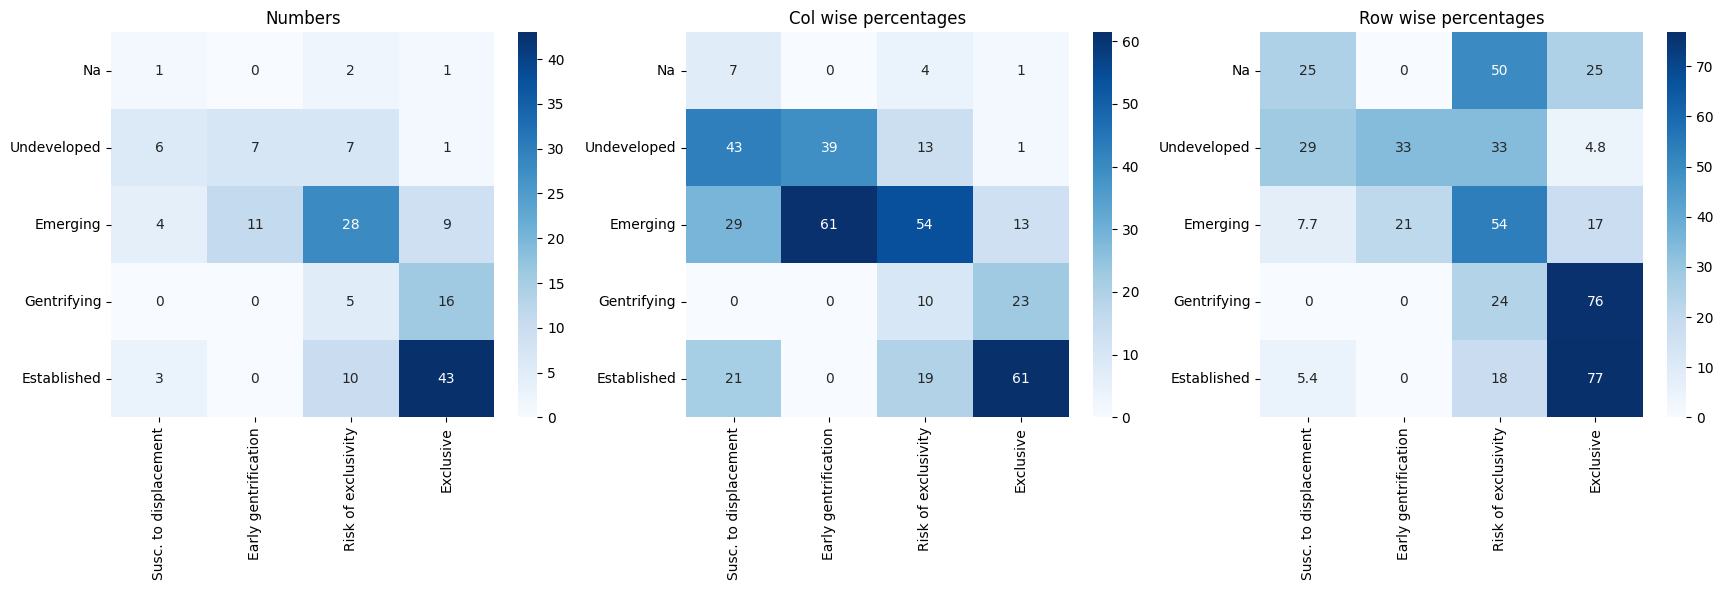

In [17]:
fig,axs=plt.subplots(ncols=3, figsize=(21,5))
sns.heatmap(crosstab, ax=axs[0], annot=True, cmap='Blues', fmt=".0f")
axs[0].set_title("Numbers")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
sns.heatmap(crosstab_col_pct, ax=axs[1], annot=True, cmap='Blues', fmt=".0f")
axs[1].set_title("Col wise percentages")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
sns.heatmap(crosstab_row_pct, ax=axs[2], annot=True, cmap='Blues')
axs[2].set_xlabel("")
axs[2].set_ylabel("")
axs[2].set_title("Row wise percentages");

fig.savefig("../Figures/Melbourne_crosstasbs.png", bbox_inches = 'tight')   

### Difference plot

In [18]:
new_mapping = {1: 0, 2: 1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4}
score_per_suburb_with_index['Classification_new'] = score_per_suburb_with_index['Classification'].map(new_mapping)
score_per_suburb_with_index['Diff'] = score_per_suburb_with_index['dominant_class'] - score_per_suburb_with_index['Classification_new']

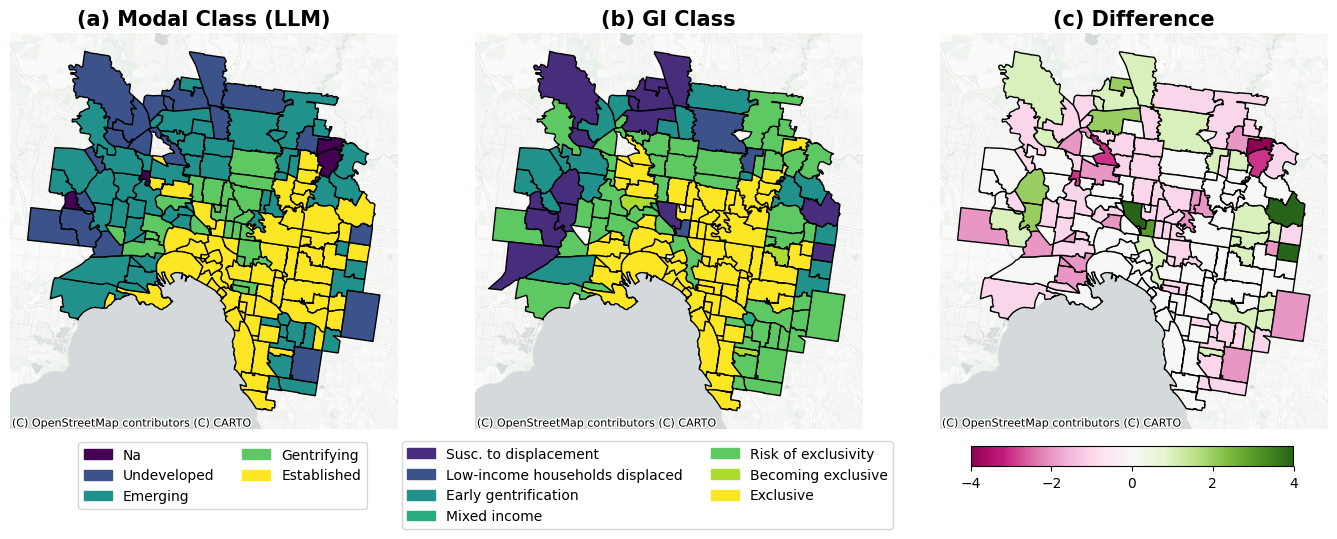

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(17, 10), sharey=True, sharex=True)
g_index_gdf = g_index_gdf.to_crs(epsg=3857)

# (a) LLM map
per_suburb_summary.plot(color=per_suburb_summary["color"], ax=axs[0], legend=False, edgecolor='black')
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_suburb_summary.loc[per_suburb_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]

# (b) GI map
g_index_gdf.plot(color=g_index_gdf["color"], ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) GI Class", fontweight='bold', fontsize=15)
axs[1].axis("off")

mapping_idx = {1: 'Susc. to displacement', 2: "Low-income households displaced",
               4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 
               7: "Becoming exclusive", 8 : "Exclusive"}
patches_gi = [mpatches.Patch(color=g_index_gdf.loc[g_index_gdf["Classification"] == k, "color"].iloc[1], 
                             label=label) for k, label in mapping_idx.items()]

# (c) Diff map with colorbar
diff_plot = score_per_suburb_with_index.plot('Diff', ax=axs[2], cmap='PiYG', legend=False, edgecolor='black')
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
axs[2].set_title("(c) Difference", fontweight='bold', fontsize=15)
axs[2].axis("off")

# --- Create legends & colorbar at the bottom ---
# 1. LLM legend
leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.25, 0.21),
                  frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

# 2. GI legend
leg2 = fig.legend(handles=patches_gi, loc='lower center', bbox_to_anchor=(0.5, 0.19),
                  frameon=True, ncol=2, prop={'size': 10})

# 3. Diff colorbar (same height as legends)
cbar_ax = fig.add_axes([0.69, 0.26, 0.19, 0.02])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=score_per_suburb_with_index['Diff'].min(), 
                             vmax=score_per_suburb_with_index['Diff'].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='PiYG'),
                    cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# plt.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at bottom for legends/cbar
fig.savefig("../Figures/Melbourne_LLLM-Score_vs_GI-Score.png", bbox_inches='tight', dpi=300)